# Phase 1: Exploratory Data Analysis (EDA) & Feature Engineering
**Project:** Nigerian-Context Fraud Detection System
**Goal:** Identify patterns in Nigerian financial transactions and engineer features that capture local fraud behaviors (USSD drains, midnight spikes, etc.).

### Objectives:
1. Load the synthetic Nigerian transaction data.
2. Analyze the distribution of fraud across different "Naira Bands."
3. Engineer 20+ features for our ML models.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.logger import get_logger
from pathlib import Path

# Initialize logger for the notebook
logger = get_logger("notebook_eda")

# Set visual style
plt.style.use('fivethirtyeight')
%matplotlib inline

# Load the data

filepath = Path("../../data/nigerian_transactions_v5.csv").resolve()
df = pd.read_csv(filepath)
df['timestamp'] = pd.to_datetime(df['timestamp'])

logger.info("Data loaded and timestamp converted.")
df.head()

[2025-12-28 23:27:27] INFO [notebook_eda.<module>:22] Data loaded and timestamp converted.


,timestamp,user_id,amount,user_avg_amount,user_balance,channel,location,sender_bank,bvn_linked,device_changed,failed_attempts_24h,tx_count_1h,tx_count_24h,fraud_reason,is_fraud
0,2024-01-01 00:00:00,USR_1735,37784.94,13441.53,107878.04,POS,Ibadan,Zenith,1,0,0,1,1,NONE,0
1,2024-01-01 00:00:48,USR_1007,26815.50,11220.40,305672.34,Mobile App,Abuja,Moniepoint,1,0,0,1,1,NONE,0
2,2024-01-01 00:01:36,USR_2160,18631.43,11018.21,938312.56,Mobile App,Abuja,Kuda,1,0,0,1,1,NONE,0
3,2024-01-01 00:02:24,USR_2222,6582.76,4567.18,706045.04,Mobile App,Lagos,OPay,1,0,5,1,1,NONE,0
4,2024-01-01 00:03:12,USR_1911,23162.14,8709.97,1343640.62,POS,Abuja,Access,0,0,0,1,1,NONE,0


##  Contextual Amount Behavior (Naira Bands)

  * Transaction amounts in Nigeria carry contextual meaning rather than absolute risk.

  * Micro transactions are commonly associated with airtime, data, and fintech micro-movements, while mid-range amounts (₦50,000–₦200,000) often align with daily transfer limits and common spending thresholds.

This explains why raw transaction amount shows only moderate correlation with fraud. An amount that appears risky in isolation may be completely legitimate during salary periods or emergency spending. Amount becomes meaningful only when combined with timing and user behavior.

In [2]:
def engineer_initial_features(data):
    df = data.copy()

    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Temporal
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['day'] = df['timestamp'].dt.day

    # Nigeria-specific temporal risk
    df['is_midnight'] = df['hour'].between(0, 4).astype(int)

    # Salary window
    df['is_salary_window'] = df['day'].isin([27, 28, 29, 30, 1, 2]).astype(int)

    # Channel indicator
    df['is_ussd'] = (df['channel'] == 'USSD').astype(int)

    return df


df_engineered = engineer_initial_features(df)
df_engineered.head()

,timestamp,user_id,amount,user_avg_amount,user_balance,channel,location,sender_bank,bvn_linked,device_changed,...,tx_count_1h,tx_count_24h,fraud_reason,is_fraud,hour,day_of_week,day,is_midnight,is_salary_window,is_ussd
0,2024-01-01 00:00:00,USR_1735,37784.94,13441.53,107878.04,POS,Ibadan,Zenith,1,0,...,1,1,NONE,0,0,0,1,1,1,0
1,2024-01-01 00:00:48,USR_1007,26815.50,11220.40,305672.34,Mobile App,Abuja,Moniepoint,1,0,...,1,1,NONE,0,0,0,1,1,1,0
2,2024-01-01 00:01:36,USR_2160,18631.43,11018.21,938312.56,Mobile App,Abuja,Kuda,1,0,...,1,1,NONE,0,0,0,1,1,1,0
3,2024-01-01 00:02:24,USR_2222,6582.76,4567.18,706045.04,Mobile App,Lagos,OPay,1,0,...,1,1,NONE,0,0,0,1,1,1,0
4,2024-01-01 00:03:12,USR_1911,23162.14,8709.97,1343640.62,POS,Abuja,Access,0,0,...,1,1,NONE,0,0,0,1,1,1,0


##  Visualizing Fraud Distribution

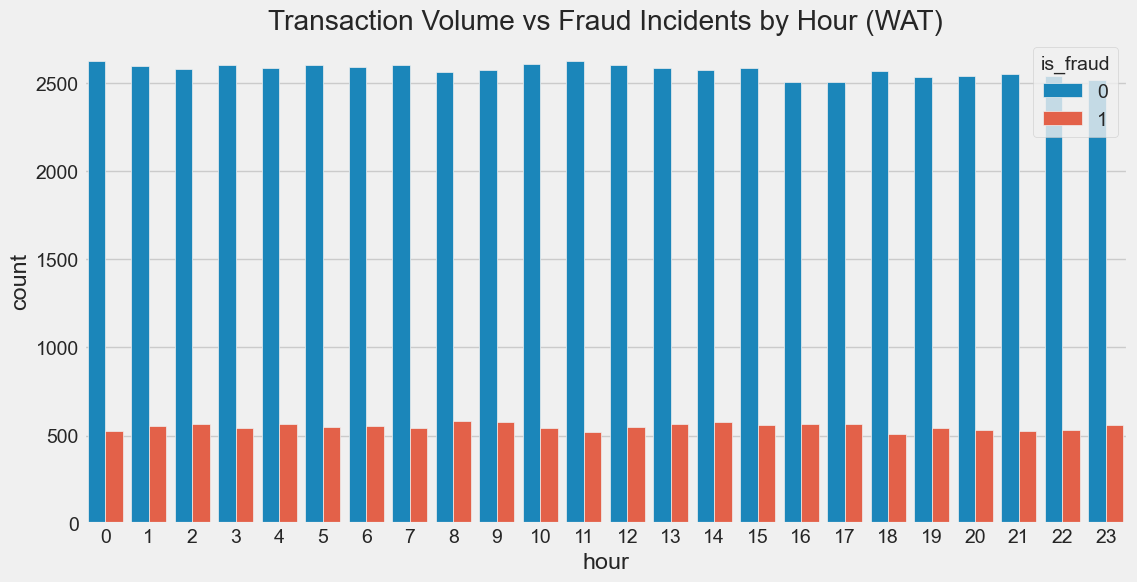

In [3]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_engineered, x='hour', hue='is_fraud')
plt.title('Transaction Volume vs Fraud Incidents by Hour (WAT)')
plt.show()

##  Capturing Momentum: Velocity Feature Engineering

In the world of Nigerian fintech, fraud isn't just about *what* happened, but *how fast* it's happening. A single ₦50,000 transfer might be normal, but five of them in 60 minutes is a red flag.

In this section, I'm implementing **Rolling Window Features**. By looking back at the last 24 hours for each user, we can calculate:
* **Transaction Frequency (`tx_count_24h`):** Are we seeing an unusual burst of activity?
* **Spend Volume (`total_spend_24h`):** Is the user's account being drained faster than their historical norm?

**Note:** I've applied a `.shift(1)` to these calculations. This is crucial—it ensures the model only sees data from *before* the current transaction, preventing it from "cheating" by looking into the future.

In [4]:
def engineer_velocity_features(data):
    df = data.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values(['user_id', 'timestamp'])

    df = df.set_index('timestamp')

    # 1. User transaction count (24h)
    df['tx_count_24h'] = (
        df.groupby('user_id')['amount']
          .rolling('24h')
          .count()
          .reset_index(level=0, drop=True).shift(1)
    )

    # 2. User total spend (24h)
    df['total_spend_24h'] = (
        df.groupby('user_id')['amount']
          .rolling('24h')
          .sum()
          .reset_index(level=0, drop=True).shift(1)
    )

    df = df.reset_index()
    return df



df_final = engineer_velocity_features(df_engineered)

##  Account Drain Dynamics (Balance Awareness)

The `pct_of_balance` feature measures how much of a user’s available balance is consumed by a single transaction.

Fraudulent behavior often attempts to drain a significant portion of the account in a short period. However, legitimate scenarios such as rent payments, school fees, or urgent expenses can produce similar patterns.

As a result, this feature exhibits meaningful but imperfect correlation with fraud, reinforcing the need for it to be interpreted alongside temporal, channel, and velocity-based signals rather than in isolation.

In [5]:
def engineer_advanced_behavioral(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    #  USER-LEVEL FEATURES
    df = df.sort_values(['user_id', 'timestamp'])

    df['amt_to_user_avg_ratio'] = df['amount'] / df['user_avg_amount']
    df['amt_to_user_avg_ratio'] = df['amt_to_user_avg_ratio'].clip(0, 10)

    df['pct_of_balance'] = (df['amount'] / df['user_balance']) * 100
    df['pct_of_balance'] = df['pct_of_balance'].clip(0, 100)

    #  LOCATION ROLLING
    df = df.sort_values(['location', 'timestamp'])
    df['location_avg_30d'] = (
        df.groupby('location')
          .rolling('30d', on='timestamp')['amount']
          .mean()
          .reset_index(drop=True).shift(1)
    )

    df['amt_to_location_avg_ratio'] = df['amount'] / df['location_avg_30d']

    # CHANNEL VELOCITY
    df = df.sort_values(['user_id', 'channel', 'timestamp'])
    df['channel_velocity_1h'] = (
        df.groupby(['user_id', 'channel'])
          .rolling('1h', on='timestamp')['amount']
          .count()
          .reset_index(drop=True).shift(1)
    )
    return df


df_finals = engineer_advanced_behavioral(df_final)


##  Precision Engineering: "Surgical" Fraud Indicators

Generic features only get us so far. To truly catch sophisticated fraud, we need to look for specific "shocks" to the system. I call these **Surgical Features** because they target very specific behavioral anomalies:

1.  **Balance Depletion Ratio:** Instead of just looking at the amount, we look at what % of the user's current balance is being moved. A 95% sweep is often a sign of a compromised account.
2.  **The Midnight High-Value Shock:** By combining temporal data (midnight to 5 AM) with value spikes (10x the user's average), we create a high-signal indicator for "SIM Swap" or "Social Engineering" fraud which often happens when the victim is asleep.
3.  **User-to-Location Ratios:** We compare the current transaction against the average activity in that specific location (Lagos vs. Kano, etc.) to see if the spending pattern is "local" or an outlier.

In [6]:
def engineer_surgical_features(data):
    df = data.copy()

    # Ensure datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])


    df = df.sort_values(['user_id', 'timestamp'])

    # 1. Balance Depletion Ratio
    df['pct_balance_withdrawn'] = df['amount'] / (df['user_balance'] + 1)

    # Clip
    df['pct_balance_withdrawn'] = df['pct_balance_withdrawn'].clip(0, 5)

    # 2. Velocity: Transactions per hour
    df['tx_per_hour'] = (
        df.groupby('user_id', group_keys=False)
          .rolling('1h', on='timestamp')['amount']
          .count()
          .reset_index(drop=True).shift(1)
    )

    # Fill NaNs
    df['tx_per_hour'] = df['tx_per_hour'].fillna(1)

    # 3. Midnight High-Value Shock
    df['hour'] = df['timestamp'].dt.hour

    df['is_midnight_high_value'] = (
        (df['hour'] < 5) &
        (df['amount'] > 10 * df['user_avg_amount'])
    ).astype(int)

    return df
df_finals = engineer_surgical_features(df_finals)

## Visualisation and Correlation with Fraud

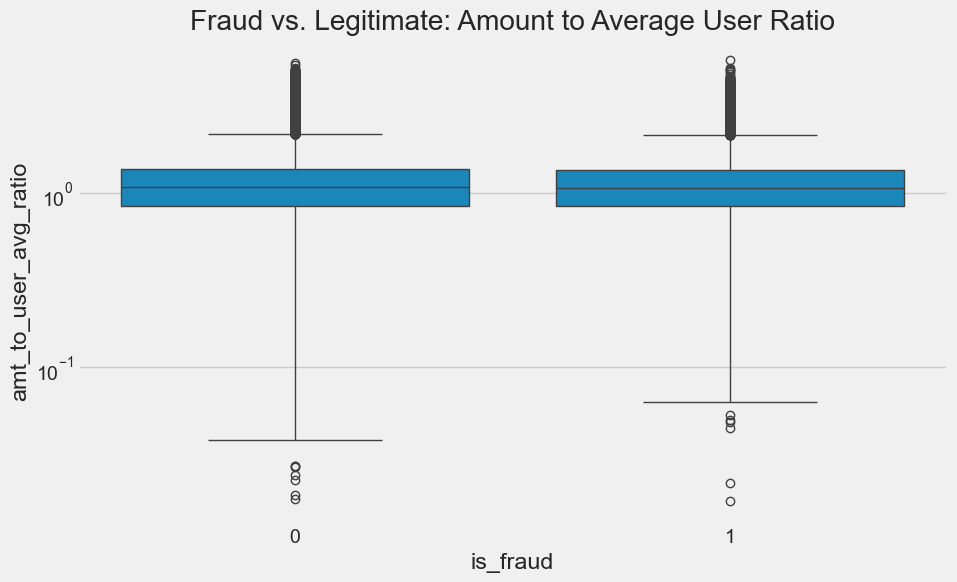

Correlation with Fraud:
is_fraud               1.000000
device_changed         0.480929
failed_attempts_24h    0.183599
tx_count_1h            0.110392
day                    0.061036
Name: is_fraud, dtype: float64


In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_fraud', y='amt_to_user_avg_ratio', data=df_finals)
plt.yscale('log')
plt.title('Fraud vs. Legitimate: Amount to Average User Ratio')
plt.show()

# Correlation check
numeric_df = df_finals.select_dtypes(include='number')

# Correlation with 'is_fraud'
print("Correlation with Fraud:")
print(numeric_df.corr()['is_fraud'].sort_values(ascending=False).head(5))


### 5. Finalize the features Engineering

In [8]:
# 1. Drop columns
cols_to_drop = ['timestamp', 'transaction_id', 'user_id']
ml_ready_df = df_finals.drop(columns=cols_to_drop, errors='ignore')

# 2. Save as Parquet
file_output = '../../data/nigerian_fraud_sentV2.parquet'
ml_ready_df.to_parquet(file_output, index=False)

logger.info(f"Gold Data Saved! Shape: {ml_ready_df.shape}")

[2025-12-28 23:27:49] INFO [notebook_eda.<module>:9] Gold Data Saved! Shape: (75000, 28)


## Conclusion & Next Steps

We’ve successfully transformed raw transaction logs into a high-dimensional "Gold" dataset. By moving beyond simple columns and engineering features that reflect **Nigerian-specific banking behaviors** (like USSD usage and salary-week spikes), we've given our future model a much better chance of success.

**Key Achievements:**
* Handled temporal logic (Midnight risks and Salary windows).
* Built rolling velocity windows to catch rapid-fire attacks.
* Normalized spending habits against individual and geographical averages.

The data is now saved in **Parquet format** to preserve data types and optimize storage for the modeling phase.